In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, Legend
from bokeh.models.widgets import Slider
from bokeh.layouts import widgetbox, column
from bokeh.plotting import figure, curdoc
from bokeh.transform import factor_cmap
from bokeh.palettes import RdYlBu
from IPython.core.display import HTML, display
import matplotlib.pyplot as plt
import seaborn as sn

pd.set_option("display.max_rows", 8)
pd.set_option("display.max_columns", 20)

# Descriptive Analytics

## United States Summary

In [2]:
# import data
cases_US = pd.read_csv('../data/US_all_vars.csv').iloc[:,1:]
cases_global = pd.read_csv('../data/Global_all_vars.csv').iloc[:,1:]

cases_US['Date'] = pd.to_datetime(cases_US['Date'], cache=True)

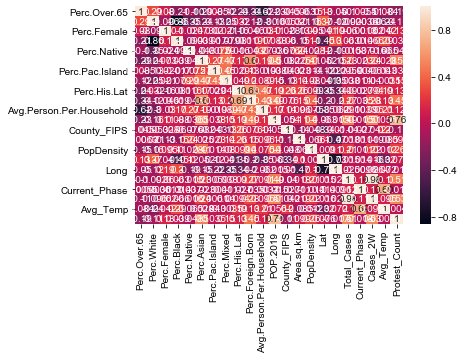

In [3]:
corr_US = cases_US.drop('FIPS',axis=1).corr()
sn.heatmap(corr_US, annot=True)
sn.set(rc={'figure.figsize':(20,20)})

display(HTML("<p style='font-size: 15px'>U.S. Correlation Plot</p>"))
plt.savefig("../assets/img/Seaborn/Corr_Plot.png")

In [4]:
def assign_color(row):
    if row['Avg.Person.Per.Household'] < 2.3:
        return '< 2.3' 
    elif row['Avg.Person.Per.Household'] >= 2.3 and row['Avg.Person.Per.Household'] <= 2.6:
        return '>= 2.3 & <= 2.6'
    elif row['Avg.Person.Per.Household'] > 2.6:
        return '> 2.6'

cases_US['Avg.Person.Per.Household.FCT'] = cases_US.apply(assign_color, axis=1)

hover = HoverTool(tooltips=[
    ("County", "@County"),
    ("State", "@State"),
    ("Avg Person Per Household", "@{Avg.Person.Per.Household.FCT}"),
    ("Population", "@{POP.2019}"),
    ("Total_Cases", "@Total_Cases")
    ])

p = figure(title = "Total Population vs Total Cases", plot_height=500, plot_width=750,
           tools=[hover, "pan,reset,wheel_zoom"])

colors = factor_cmap('Avg.Person.Per.Household.FCT', palette=['#EC7063','#A569BD','#007BCC'],
                     factors=cases_US['Avg.Person.Per.Household.FCT'].unique()) 

p.add_layout(Legend(), 'right')

p.circle('POP.2019','Total_Cases', legend='Avg.Person.Per.Household.FCT',
         fill_alpha=0.1, size=10, fill_color=colors, line_color=colors,
         source=ColumnDataSource(cases_US[cases_US['Date'] == pd.Timestamp("2020-06-30")]))
p.xaxis.axis_label = 'Population 2019 (thousands)'
p.yaxis.axis_label = 'Total COVID-19 Cases (06/30/2020)'
p.legend.title = 'Avg Person Per Household'

output_file("../assets/img/Bokeh/Total_Pop_Plot.html")

cases_US = cases_US.drop(['Avg.Person.Per.Household.FCT'], axis=1)
show(p)

In [5]:
%%html
<iframe src="/assets/img/Bokeh/Total_Pop_Plot.html"
    sandbox="allow-same-origin allow-scripts"
    width="100%"
    height="500"
    scrolling="no"
    seamless="seamless"
    frameborder="0">
</iframe>

In [6]:
hover = HoverTool(tooltips=[
    ("County", "@County"),
    ("State", "@State"),
    ("Protest_Count", "@Protest_Count"),
    ("Total_Cases", "@Total_Cases"),
    ("Governer.Party", "@{Governer.Party}")
    ])

p = figure(title = "Total Cases of COVID-19 (as of 6/30/20) vs BLM Protest Count by County",
           plot_height=500, plot_width=750, tools=[hover, "pan,reset,wheel_zoom"])

colors = factor_cmap('Governer.Party', palette=['red', 'blue'], factors=cases_US['Governer.Party'].unique()) 

p.circle('Protest_Count','Total_Cases', legend='Governer.Party',
         fill_alpha=0.1, size=10, fill_color=colors, line_color=colors,
         source=ColumnDataSource(cases_US[cases_US['Date'] == pd.Timestamp("2020-06-30")]))

p.legend.title = 'Political Party of Governer'
p.xaxis.axis_label = 'BLM Protest Count'
p.yaxis.axis_label = 'Total COVID-19 Cases (06/30/2020)'

output_file("../assets/img/Bokeh/BLM_Gov_Cases_Plot.html")
show(p)

In [7]:
%%html
<iframe src="/assets/img/Bokeh/BLM_Gov_Cases_Plot.html"
    sandbox="allow-same-origin allow-scripts"
    width="100%"
    height="500"
    scrolling="no"
    seamless="seamless"
    frameborder="0">
</iframe>

In [8]:
def assign_density(row):
    if row['PopDensity'] < 500:
        return '< 500' 
    elif row['PopDensity'] >= 500 and row['PopDensity'] <= 1000:
        return '>= 500 & <= 1000'
    elif row['PopDensity'] > 1000:
        return '> 1000'

cases_US['PopDensity.FCT'] = cases_US.apply(assign_density, axis=1)

cases_US_bar = cases_US.groupby(['County', 'State']).agg({
    'Total_Cases': np.max, 
    'PopDensity.FCT': pd.Series.mode
}).reset_index()

cases_US_bar['Location'] = cases_US_bar[['County', 'State']].apply(lambda x: ', '.join(x), axis=1)

cases_US_bar = cases_US_bar.sort_values(by=['Total_Cases'], ascending=False)
cases_US_bar = cases_US_bar[:20]

Location = cases_US_bar['Location'].unique()
Density = cases_US_bar['PopDensity.FCT'].unique()

hover = HoverTool(tooltips=[
    ("County/State", "@Location"),
    ("PopDensity", "@{PopDensity}"),
    ("Total_Cases", "@Total_Cases")
    ])

pal = RdYlBu[10]
source = ColumnDataSource(data=dict(Location=cases_US_bar['Location'],
                                    PopDensity=cases_US_bar['PopDensity.FCT'],
                                    Total_Cases=cases_US_bar['Total_Cases']/1000))

p = figure(x_range=Location, y_range=(0,max(cases_US_bar['Total_Cases']/1000)+25), 
           plot_height=500, title="Total COVID-19 Cases by Top 20 Counties as of 6/30/20", 
           toolbar_location=None, tools=[hover, "pan,reset,wheel_zoom"])

p.add_layout(Legend(), 'right')

p.vbar(x='Location', top='Total_Cases', width=0.9, legend="PopDensity",source=source,
       fill_color=factor_cmap('PopDensity', palette=pal, factors=Density))

p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = "vertical"

p.legend.title = 'County'
p.xaxis.axis_label = 'U.S. County'
p.yaxis.axis_label = 'Total COVID-19 Cases (Thousands)'

output_file("../assets/img/Bokeh/County_Density_Plot.html")
show(p)

In [9]:
%%html
<iframe src="/assets/img/Bokeh/County_Density_Plot.html"
    sandbox="allow-same-origin allow-scripts"
    width="100%"
    height="500"
    scrolling="no"
    seamless="seamless"
    frameborder="0">
</iframe>

In [10]:
plot_name = "Lockdown_Rating_Plot"

cases_US_bar = cases_US[cases_US['Date'] == pd.Timestamp('2020-06-30')]
cases_US_bar = cases_US_bar.groupby('State').agg({
    'Total_Cases': np.sum,
    'Restriction Rating': pd.Series.mode
}).reset_index()
cases_US_bar = cases_US_bar.sort_values(by=['Total_Cases'], ascending=False)
cases_US_bar = cases_US_bar[:10]

State = cases_US_bar['State'].unique()
Ratings = cases_US_bar['Restriction Rating'].unique()

hover = HoverTool(tooltips=[
    ("State", "@State"),
    ("Restriction Rating", "@{Restrictions}"),
    ("Total_Cases", "@Total_Cases")
    ])

pal = RdYlBu[5]
source = ColumnDataSource(data=dict(State=cases_US_bar['State'],
                                    Restrictions=cases_US_bar['Restriction Rating'],
                                    Total_Cases=cases_US_bar['Total_Cases']/1000))

p = figure(x_range=State, y_range=(0,max(cases_US_bar['Total_Cases']/1000)+25), 
           plot_height=450, title="Total COVID-19 Cases by Top 10 Counties as of 6/30/20", 
           toolbar_location=None, tools=[hover, "pan,reset,wheel_zoom"])

p.add_layout(Legend(), 'right')

p.vbar(x='State', top='Total_Cases', width=0.9, legend="Restrictions",
       fill_color=factor_cmap('Restrictions', palette=pal, factors=Ratings), source=source)

p.xgrid.grid_line_color = None
p.xaxis.major_label_orientation = "vertical"

p.legend.title = 'State Lockdown Restrictions'
p.xaxis.axis_label = 'U.S. County'
p.yaxis.axis_label = 'Total COVID-19 Cases (Thousands)'

output_file("../assets/img/Bokeh/Lockdown_Rating_Plot.html")
show(p)

In [11]:
%%html
<iframe src="/assets/img/Bokeh/Lockdown_Rating_Plot.html"
    sandbox="allow-same-origin allow-scripts"
    width="100%"
    height="500"
    scrolling="no"
    seamless="seamless"
    frameborder="0">
</iframe>